In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
from collections import Counter, OrderedDict
from IPython import display
from tqdm import trange, tqdm, tqdm_notebook

%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
data = pd.read_csv('data_etsy.csv').drop('Unnamed: 0', axis=1)

In [5]:
data.head()

,id,description
0,116574664,THIS LISTING IS FOR ONE DIGITAL PDF VERSION OF...
1,687895649,This is 2 Two US Buffalo / Indian Head Nickels...
2,624841393,Dichroic Earrings - Orange Yellow Gold Blue G...
3,687895641,".SVG, .EPS, .PNG, .PDF, .DXF and .JPG Instant ..."
4,650279436,Make your bathroom from drab to fabulous with ...


In [6]:
data.shape

(3000, 2)

In [7]:
texts = data['description']

In [8]:
texts[:5]

0    THIS LISTING IS FOR ONE DIGITAL PDF VERSION OF...
1    This is 2 Two US Buffalo / Indian Head Nickels...
2    Dichroic Earrings  - Orange Yellow Gold Blue G...
3    .SVG, .EPS, .PNG, .PDF, .DXF and .JPG Instant ...
4    Make your bathroom from drab to fabulous with ...
Name: description, dtype: object

In [9]:
start_token = '¿'
end_token = '¡'
texts = list(map(lambda t: start_token + t + end_token, texts))

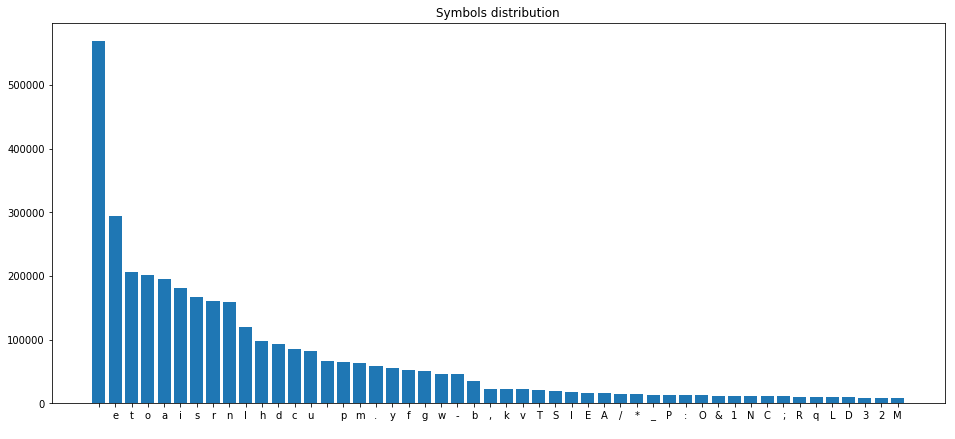

Wall time: 26.1 s


In [10]:
%%time
letters = sum([list(t) for t in texts], [])
letters_count = OrderedDict(sorted(Counter(letters).items(), key=lambda x: x[1], reverse=True))

n = 50

plt.figure(figsize=(16,7))
plt.title('Symbols distribution')
plt.bar(range(n), list(letters_count.values())[:n], align='center')
plt.xticks(range(n), list(letters_count.keys())[:n])
plt.show()

max length = 11786


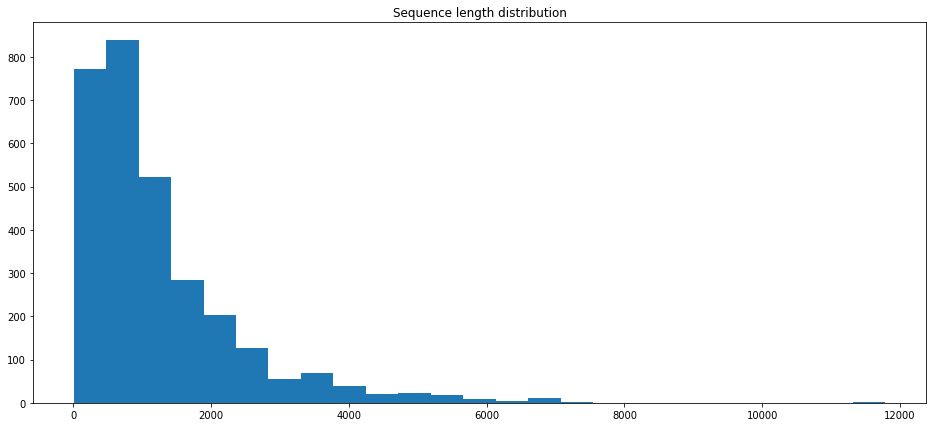

In [11]:
MAX_LENGTH = max(map(len,texts))
print("max length =", MAX_LENGTH)

plt.figure(figsize=(16,7))
plt.title('Sequence length distribution')
plt.hist(list(map(len,texts)), bins=25)
plt.show()

In [12]:
# tokens <-> indices
    
tokens = [start_token, end_token] + sorted(list(set(letters) - {start_token, end_token}))
    
tok2id = {tok: i for i, tok in enumerate(tokens)}
id2tok = {i: tok for tok, i in tok2id.items()}

n_tokens = len(tokens)
print ('There are {} tokens',n_tokens)

print('Vocabular: ' + "".join(tokens))

There are {} tokens 471
Vocabular: ¿¡	
 !"#$%&()*+,-./0123456789:;=?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¢£¤§¨©®¯°±²´·¸º»¼½¾ÄÇÓÖ×ÜßàáâäæçèéêíîñóôõöøúüİıĸœΕΚΨαινσυωСТвемнстхяєѕғ֍۩ૐஐ๑ღ    ​‍–—―‘’“”„•‣… ‬‭″›⁞€℃ℓ№™ℴℹ⅛⅜⅞→↓↜↝↣⇐⇒−∗∙≈≔≕≪≫⋅⏩①②③ⓔⓛⓞⓥ─━═▄▐░■▪▬▲▶▷▸►▼◀◄◆◈◊○●◘◙◻◼◾★☆☑☛☝☞☹☺☼☽♛♡♥♦♪♫⚑⚓⚠⚤⚫✂✃✄✅✈✉✋✍✓✔✘✣✤✦✧✨✩✪✮✯✱✶✷✿❀❄❊❑❘❙❚❣❤❥➔➜➝➡➤➫➳➽⤸⫷⫸⭐【】〰・︎️︱！，：＠𝐀𝐁𝐂𝐃𝐄𝐆𝐇𝐈𝐊𝐋𝐌𝐍𝐎𝐏𝐑𝐒𝐓𝐔𝐖𝐗𝐘𝐙𝐚𝐜𝐝𝐞𝐟𝐠𝐡𝐢𝐥𝐦𝐧𝐨𝐩𝐪𝐫𝐬𝐭𝐮𝐯𝐱𝐲𝐳𝗔𝗕𝗖𝗗𝗘𝗙𝗛𝗜𝗡𝗢𝗣𝗥𝗦𝗧𝗨𝗪𝗬🅰🅲🅳🅾🅿🆁🆂🆃🆄🌊🌜🌟🌴🌵🌹🌺🌿🍭🍵🎀🎁🎈🎉🎗🎨🏻👀👉👋👌👍👜👦👨👩💃💌💎💕💖💗💚💛💝💬💮💰📄📍📏📝📣📤📥📦📧📨🔍🔔🔸😃😉😊😘🚫🛁🛒🡻🤙🧢


In [13]:
def to_matrix(texts, max_len=None, pad=tok2id[start_token], dtype=np.int64):
    """Casts a list of texts into rnn-digestable matrix"""
    
    if max_len:
        max_len = max_len
    else:
        max_len = max(map(len, texts))
    texts_ix = np.zeros([len(texts), max_len], dtype) + pad

    for i in range(len(texts)):
        text_ix = list(map(tok2id.get, texts[i]))
        texts_ix[i, :len(texts[i])] = text_ix[:max_len]

    return texts_ix

In [14]:
print('\n'.join([
    start_token + 'hello world!' + end_token,
    start_token + 'hello' + end_token,
    start_token + 'hi my name is' + end_token
]))

¿hello world!¡
¿hello¡
¿hi my name is¡


In [15]:
print(to_matrix([
    start_token + 'hello world!' + end_token,
    start_token + 'hello' + end_token,
    start_token + 'hi my name is' + end_token
]))

[[ 0 76 73 80 80 83  7 91 83 86 80 72  8  1  0]
 [ 0 76 73 80 80 83  1  0  0  0  0  0  0  0  0]
 [ 0 76 77  7 81 93  7 82 69 81 73  7 77 87  1]]


In [16]:
print(to_matrix([
    start_token + 'hello world!' + end_token,
    start_token + 'hello' + end_token,
    start_token + 'hi my name is' + end_token
], max_len=8))

[[ 0 76 73 80 80 83  7 91]
 [ 0 76 73 80 80 83  1  0]
 [ 0 76 77  7 81 93  7 82]]


In [17]:
# train/test split
np.random.seed(13)

def split_data(data, train_size=0.8):
    train_index = np.random.choice(range(len(data)), size=int(train_size * len(data)), replace=False)
    val_index = np.delete(np.arange(len(data)), train_index)
    data = np.array(data)
    return data[train_index][:300], data[val_index][:200]

train_data, val_data = split_data(texts)

len(train_data), len(val_data)

(300, 200)

## Char-RNN

In [133]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, cell="rnn", n_layers=1):
        super(CharRNN, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.cell = cell
        
        self.embeddings = nn.Embedding(vocab_size, hidden_size)
        if self.cell == 'rnn':
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        elif self.cell == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.cell == 'lstm':
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        bs = input.size(0)
        embedded = self.embeddings(input)
        reordered = embedded.view(1, bs, -1)
        out, hidden = self.rnn(reordered, hidden)
        # ['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0']
        out = self.decoder(out)
        return out.view(bs, -1), hidden

    def init_hidden(self, batch_size):
        if self.cell == "lstm":
            return (torch.zeros(self.n_layers, batch_size, self.hidden_size),
                    torch.zeros(self.n_layers, batch_size, self.hidden_size))
        
        return torch.zeros(self.n_layers, batch_size, self.hidden_size)
    
    def get_params(self):
        return (self.rnn._parameters['weight_ih_l0'],
                self.rnn._parameters['weight_hh_l0'],
                self.rnn._parameters['bias_ih_l0'],
                self.rnn._parameters['bias_hh_l0'])

In [134]:
batch_size = 32
max_len = 1000

texts_train = np.array(to_matrix(train_data, max_len=max_len))
texts_val = np.array(to_matrix(val_data, max_len=max_len))

dataset_train = utils.TensorDataset(torch.stack([torch.Tensor(i) for i in texts_train]))
dataset_val = utils.TensorDataset(torch.stack([torch.Tensor(i) for i in texts_val]))

train_loader = utils.DataLoader(dataset_train, batch_size=batch_size)
val_loader = utils.DataLoader(dataset_val, batch_size=batch_size)

In [135]:
texts_train.shape

(300, 1000)

In [136]:
for x in train_loader:
    pass

In [137]:
print(x[0].shape)

torch.Size([12, 1000])


In [147]:
n_hidden = 16

model = CharRNN(n_tokens, n_hidden, n_tokens).to(device)

train_size = len(train_data)
val_size = len(val_data)

def set_random_seeds(seed_value=13, device='cpu'):
    '''source https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5'''
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


def train(model, optimizer, epochs_n=1, batch_size=batch_size):
    model.to(device)
    
    train_loss_curve = [np.nan] * epochs_n
    val_loss_curve = [np.nan] * epochs_n
    min_val_loss = 0
    min_val_accuracy_epoch = 0

    batches_n = (train_size - 1) // batch_size + 1
    
    train_weights_ih_l0 = torch.empty(epochs_n * batches_n, n_hidden, n_hidden)
    
    j = 0
    
    print(train_weights_ih_l0.shape)
    
    for epoch in range(epochs_n):
        model.train()
        train_loss_curve[epoch] = 0
        for x in tqdm(train_loader):
            x = x[0].to(device).long()
            hidden = model.init_hidden(x.shape[0]).to(device)
            loss = 0.0
            for i in range(x.shape[1] - 1):
                out, hidden = model.forward(x[:, i], hidden)
                loss += F.cross_entropy(out, x[:, i + 1])
            train_loss_curve[epoch] += loss
            loss.backward()
            optimizer.step()
            
            weight_ih_l0, _, _, _ = model.get_params()
            train_weights_ih_l0[j] = weight_ih_l0
            j += 1
        
        display.clear_output(wait=True)
        plt.figure(figsize=(13, 6))
        train_loss_curve[epoch] /= batches_n
        plt.plot(train_loss_curve, label='train')

        model.eval()
        
        val_loss_curve[epoch] = 0
        for x in tqdm(val_loader):
            x = x[0].to(device).long()
            hidden = model.init_hidden(x.shape[0]).to(device)
            loss = 0.0
            for i in range(x.shape[1] - 1):
                out, hidden = model.forward(x[:, i], hidden)
                loss += F.cross_entropy(out, x[:, i + 1])
            val_loss_curve[epoch] += loss
        
        val_loss_curve[epoch] /= (val_size - 1) // batch_size + 1
        plt.plot(val_loss_curve, label='val')
        plt.title('Loss: train {:.4f}, val {:.4f}'.format(train_loss_curve[epoch], val_loss_curve[epoch]))
        plt.legend(loc='best')

        plt.tight_layout()
        plt.show()
    return train_weights_ih_l0

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.20it/s]


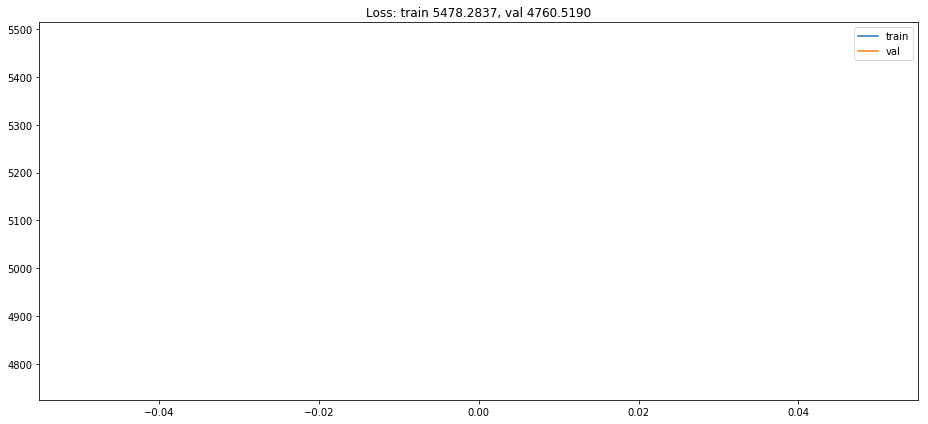

In [148]:
set_random_seeds(device=device)
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
train_weights_ih_l0 = train(model, opt)

In [168]:
train_weights_ih_l0_np = train_weights_ih_l0.detach().numpy()
last_weights_ih_l0 = train_weights_ih_l0_np[-1]

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

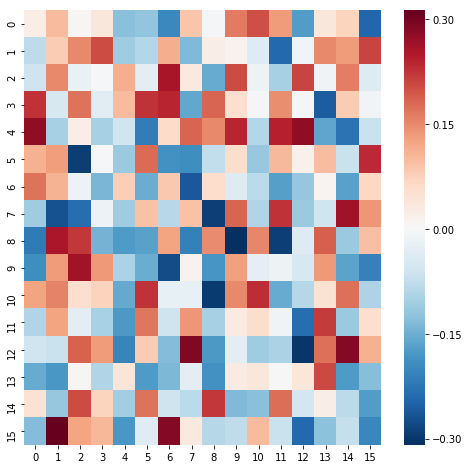

In [171]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(last_weights_ih_l0, ax=ax, cmap='RdBu_r')